In [47]:
import json
import requests
import os, re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# ENDPOINT_LEGACY = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
ENDPOINT_LEGACY = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access}/{granularity}/{start}/{end}'

ENDPOINT_PAGEVIEWS = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

# Customize these with your own information
HEADERS = {
    'User-Agent': 'https://github.com/nmnshrma',
    'From': 'namans3@uw.edu'
}

API = {'pagecounts': ENDPOINT_LEGACY,
       'pageviews': ENDPOINT_PAGEVIEWS}

API_ACCESS = {'pagecounts': ['desktop-site', 'mobile-site'],
              'pageviews': ['desktop','mobile-app','mobile-web']}

JSON_FILENAME = "{apiname}_{accesstype}_{firstmonth}-{lastmonth}.json"

In [4]:
# SAMPLE parameters for getting aggregated legacy view data 
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
params_legacy = {"project" : "en.wikipedia.org",
                 "access" : "desktop-site",
                 # "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"}

# SAMPLE parameters for getting aggregated current standard pageview data
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2019090100'}

api_params = {'pagecounts': params_legacy,
              'pageviews': params_pageviews}

In [5]:
def api_data(endpoint: str, parameters: dict, headers: dict) -> dict:
    
    call = requests.get(API[endpoint].format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [6]:
def save_json(endpoint: str, start_date: str=None, end_date: str=None) -> None:
    
    if start_date and end_date:
        api_params[endpoint]["start"]=start_date
        api_params[endpoint]["end"]=end_date
    
    for access in API_ACCESS[endpoint]:
        api_params[endpoint]["access"]=access
        
        json_data = api_data(endpoint=endpoint, parameters=api_params[endpoint], headers=HEADERS)

        name_file = JSON_FILENAME.format(apiname=endpoint, accesstype=access,
                                         firstmonth=api_params[endpoint]["start"][:6],
                                         lastmonth=api_params[endpoint]["end"][:6])
        
        json.dump(obj=json_data, fp=open(name_file, 'w'))
    return None

In [7]:
def fetch_data_main():
    
    for endpoint in API:
        save_json(endpoint=endpoint)

In [8]:
def process_json() -> dict:
    """
    processes and stores all json files in the current directory, fetched from fetch_data_main
    """
    
    # Lists all json files in the current directory:
    json_files = [file_ for file_ in os.listdir() if file_.endswith(".json")]
    
    # final dict store for all dfs fetched from json
    json_df = {}
    
    for file_ in json_files:

        with open(file_, 'r') as f_:
            df=pd.DataFrame(json.load(f_)['items'])
        f_.close()


        if 'access-site' in df.columns:
            df.rename(columns={'access-site':'access'}, inplace=True)
        if 'count' in df.columns:
            df.rename(columns={'count':'views'}, inplace=True)


        # Converting the column name for 'views' to :
        # {'pageview'|'pagecount'}_{'mobile'|'desktop'}_views
        view_col_name_new = re.search('^([^\_]{1,})\_{1}.*$', file_).group(1)[:-1]+'_'
        view_col_name_new += re.search('^[^\_]{1,}\_{1}([a-z]{1,})[^a-z]{1}.*$', file_).group(1)
        view_col_name_new += '_views'
        df.rename(columns={'views':view_col_name_new}, inplace=True)


        df['year'] = df['timestamp'].map(lambda x: x[0:4])
        df['month'] = df['timestamp'].map(lambda x: x[4:6])
        
        key_name = re.search('^([^\_]{1,})\_{1}.*$', file_).group(1)[:-1]
        key_name += '_'+re.search('^[^\_]{1,}\_{1}([^\_]{1,})\_|\-{1}.*$', file_).group(1)
        json_df[key_name] = df[['timestamp', 'year', 'month', view_col_name_new]]
    
    return json_df


In [44]:
def store_csv() -> None:
    
    json_df = process_json()
    
    map_dict = dict(zip(json_df['pageview_mobile-app']['timestamp'],
                        json_df['pageview_mobile-app']['pageview_mobile_views']))
    
    json_df['pageview_mobile-web']['pageview_mobile_views']+=json_df['pageview_mobile-web']['timestamp'].map(lambda x: 
                                                                                                         map_dict.get(x, 0))
    json_df['pageview_mobile-app'] = None
    
    desktop_views_df = json_df['pageview_desktop'].merge(json_df['pagecount_desktop-site'],
                                                        how='outer',
                                                        on=['timestamp', 'year', 'month'])
    mobile_views_df = json_df['pageview_mobile-web'].merge(json_df['pagecount_mobile-site'],
                                                           how='outer',
                                                           on=['timestamp', 'year', 'month'])
    
    all_df = desktop_views_df.merge(mobile_views_df,
                                   how='outer',
                                   on=['timestamp', 'year', 'month'])
    # all_df.fillna(0, inplace=True)
    
    all_df['pagecount_all_views'] = all_df['pagecount_desktop_views']+all_df['pagecount_mobile_views']
    all_df['pageview_all_views'] = all_df['pageview_desktop_views']+all_df['pageview_mobile_views']
    
    store_cols = ['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 
                  'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views', 
                  'pageview_mobile_views']
    
    all_df[store_cols].to_csv('en-wikipedia_traffic_200712-201809.csv', index=False)
    return None

In [48]:
def read_and_plot(file_name: str) -> None:
    
    df = pd.read_csv(file_name)
    
    df.replace(0, np.nan)
    
    plt.style.use('seaborn-whitegrid')

    fig = plt.figure(figsize=(16,8))
    ax = plt.axes()

    df['datetime'] = pd.to_datetime((df.year*10000+df.month*100+1).apply(str),format='%Y%m%d')

    # Generate time series plot
    plt.plot(df['datetime'], df['pagecount_desktop_views'], color = 'blue', linestyle ='dotted',
            label='desktop traffic - legacy')
    plt.plot(df['datetime'], df['pageview_desktop_views'], color = 'blue', label='desktop traffic')

    plt.plot(df['datetime'], df['pagecount_mobile_views'], color = 'green', linestyle ='dotted',
            label='mobile traffic - legacy')
    plt.plot(df['datetime'], df['pageview_mobile_views'], color = 'green', label='mobile traffic')

    plt.plot(df['datetime'], df['pagecount_all_views'], color = 'black', linestyle ='dotted',
            label='all traffic - legacy')
    plt.plot(df['datetime'], df['pageview_all_views'], color = 'black', label='all traffic')

    ax.set(ylabel="PageViews in 10 Bn",
           xlabel="Date", 
           title="English Wikipedia Web Traffic")

    plt.legend(frameon=True)
    plt.show()

    fig.savefig('pageviews.jpg')
    
    return None


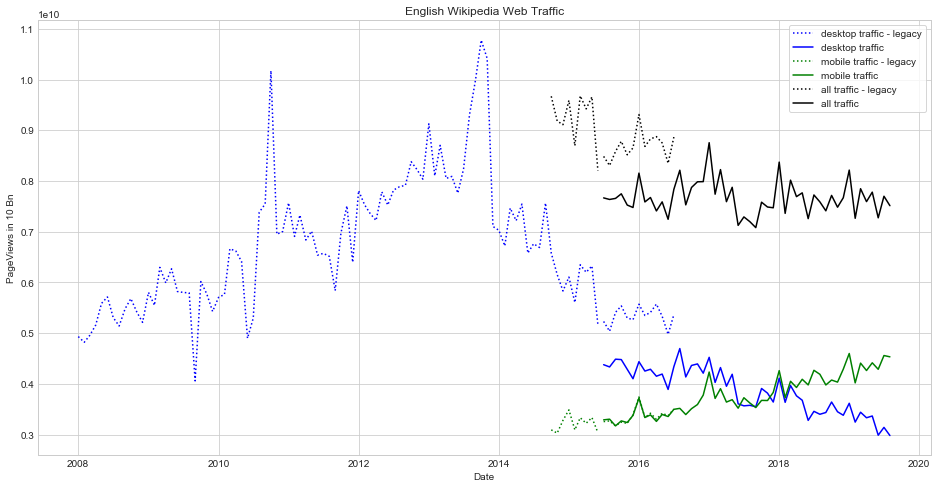

In [50]:
fetch_data_main()
store_csv()
read_and_plot('en-wikipedia_traffic_200712-201809.csv')